
# Epidemic spreading analysis

Networks (and network simulation), are a key tool in trying to predict the spread of worldwide pandemics. Many governments using modelling and simulation software to help them make decisions during an epidemic outbreak. Here, the aim is to build a simple model of disease spread on different artificial networks and investigate different vaccination policies to try and prevent or slow down the spread of the pandemic.


**Susceptible, Infected, Removed (SIR).**

Disease spread can be modelled in various ways using networks; The network built here is where nodes represent people and edges between two nodes indicate whether these two people have sufficient contact (interaction) such that a disease has a non-zero probability of transmission.

Each node (person) in the network can be in one of 3 possible states: 

1. Susceptible (the default state) - indicating the person may contract the disease if one of their neighbours has the disease.

2. Infected - the person currently has the disease and can infect their neighbours.

3. Removed - the person has either recovered from the disease and is no longer infectious (and cannot contract the disease again) or the person has died.

SIR is applicable in many real world diseases, e.g., HIV, chicken pox, etc. The following system of differential equations can be used to describe the SIR model:

$$
\frac{ds}{dt} = -\beta i(t) s(t)
\hspace{1in}
\frac{di}{dt} = \beta i(t) s(t) - \alpha i(t)
\hspace{1in}
\frac{dr}{dt} = \alpha i(t)
$$

where $\alpha$ and $\beta$ describe the rate of removal (fraction of people moving from infected to removed per time unit) and the rate of infection (fraction of people moving from susceptible to infected per time unit) respectively.
The assumption is of a well mixed population, i.e., every person has a chance of infecting every other person. In many real world scenarios this assumption is unlikely, since people usually only interact within their social circle. So, they will only contract and transmit the disease from/ to people with whom they had personal contact. However, it is still interesting to try and understand how the network structure impacts the spread, or how it might enable effective vaccination strategies.

In this network-based model, each infected node has a probability of transmitting the disease to each of its immediate neighbours with probability $\beta$ at each time step. Infected nodes also have a probability of recovering from the disease at each time step, with probability $\alpha$. 


*import libraries*

In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
from __future__ import unicode_literals 
import random 
from tqdm import tqdm 
import sys 
import operator 
from enum import * 
import copy

In [2]:
class State(Enum): 
    # define the three states of the nodes.
    Succeptible = 0
    Infected = 1
    Removed = 2
    

In [3]:
def reset(G):
    """ Initialise/reset all the nodes in the network to be susceptible, before start of experiment"""
    nx.set_node_attributes(G, State.Succeptible, 'state')


In [4]:
def initialise_infection(G, num_to_infect):
    """Set the state of a random selection of nodes to be infected"""
    nodes_to_infect = random.sample(G.nodes(), num_to_infect)
    for n in nodes_to_infect:
        G.nodes[n]['state'] = State.Infected
    return nodes_to_infect

def get_infection_stats(G):
    """Creates lists of nodes in the graph G that are susceptible, infected and removed"""
    infected = [] 
    succeptible = [] 
    removed = [] 
    for n in G:
        if G.nodes[n]['state'] == State.Infected:
            infected.append(n)
        elif G.nodes[n]['state'] == State.Succeptible:
            succeptible.append(n)
        else:
            removed.append(n)
    return succeptible, infected, removed 

def execute_one_step(G, model):
    """execute the infection model"""
    new_nodes_to_infect=[] 
    new_nodes_to_remove=[]    
    for n in G: 
        i,remove = model(n, G) #execute transmission model on node n
        new_nodes_to_infect = new_nodes_to_infect + i #
        if remove: 
            new_nodes_to_remove.append(n) 
    apply_infection(G, new_nodes_to_infect, new_nodes_to_remove)

def apply_infection(G, list_of_newly_infected, list_of_newly_removed):
    for n in list_of_newly_infected:
        G.nodes[n]['state'] = State.Infected
    for n in list_of_newly_removed:
        G.nodes[n]['state'] = State.Removed

def print_infection_stats(G):
    """Prints the number of susceptible, infected and removed nodes in graph G."""
    s,i,r = get_infection_stats(G)
    print("Susceptible: %d Infected: %d Removed %d"% (len(s),len(i),len(r)))

def draw_network_to_file(G,pos,t, initially_infected):
    # create the layout
    states = []
    for n in G.nodes():
        if n in initially_infected:
            states.append(3)
        else:
            states.append(G.nodes[n]['state']) 
    from matplotlib import colors
    cmap = colors.ListedColormap(['green', 'blue','red', 'yellow'])
    bounds=[0,1,2,3]

    # draw all nodes and edges
    nx.draw_networkx_nodes(G,pos,cmap=cmap,alpha=0.5,node_size=170, node_color=states)
    nx.draw_networkx_edges(G,pos,alpha=0.075)
    plt.savefig("images/g"+str(t)+".png")
    plt.clf()

In [5]:
# Runs single simulation of infection on the graph G, using the specified model. 
def run_spread_simulation(G, model, initial_infection_count, run_visualise=False):
    initially_infected = initialise_infection(G, initial_infection_count)

    s_results = []
    i_results = []
    r_results = []

    dt = 0
    s,i,r = get_infection_stats(ba)
    
    pos = nx.spring_layout(G, k=.75)
    
    while len(i) > 0:
        execute_one_step(G, model) 
        dt += 1 
        s,i,r = get_infection_stats(G) #calculate SIR stats 
        s_results.append(len(s)) 
        i_results.append(len(i)) 
        r_results.append(len(r)) 
        sys.stderr.write('\rInfected: %d time step: %d' % (len(i), dt))
        sys.stderr.flush()
        if run_visualise: 
            draw_network_to_file(G,pos,dt,initially_infected)
    return s_results, i_results, r_results, dt, initially_infected 

## Setting up model/ experiment

In the first experiments, these parameters are specified:

1. Size of network $N$
2. The network 
3. The transmission model $m$ that specifies how a node infects others
4. The number of people for early infection


In [6]:
def transmission_model_factory(beta=0.03, alpha=0.05):
    """
    beta: specifies the rate of infection (movement from S to I)
    alpha: specifies the rate of removal (movement from I to R)"""
    def m(n, G):
        list_of_neighbours_to_infect = [] #list of neighbours infected 
        removeMyself = False 
        if G.nodes[n]['state'] == State.Infected:
            # infect susceptible neighbours with probability beta
            for k in G.neighbors(n):
                if G.nodes[k]['state'] == State.Succeptible:
                    if random.random() <= beta: 
                        list_of_neighbours_to_infect.append(k)
            if random.random() <= alpha:
                removeMyself = True
        return list_of_neighbours_to_infect, removeMyself
    return m

*build initial network*

In [7]:
# size of network
N = 1000 
# the network
ba = nx.barabasi_albert_graph(N, 3) 
# transmission model
m = transmission_model_factory(0.03, 0.05) 
# number of people infected early
number_initial_infections = 10

## Running first experiment
After running experiment, few important metrics will be plotted:

1. Peak Incidence
2. Peak Time
3. Total Infected

Peak incidence is the maximum number of infections at a single time step. 
<br> The Peak Time indicates the time step at which we reach the peak incidence. 
<br> Total infected indicates the number of Susceptible -> Infected transitions. *[Note this is not the same as the final removed size, the final removed also includes the vaccinations, and the initially infected nodes.]*

In [8]:
# plotting SIR after experiments
def plot_infection(S,I,R,G):
    peak_incidence = max(I)
    peak_time = I.index(max(I))
    total_infected = S[0]-S[-1]

    fig_size= [18,13]
    plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
    xvalues = range(len(S))
    plt.plot(xvalues, S, color='g', linestyle='-', label="S")
    plt.plot(xvalues, I, color='b', linestyle='-', label="I")
    plt.plot(xvalues, R, color='r', linestyle='-', label="R")
    plt.axhline(peak_incidence, color='b', linestyle='--', label="Peak Incidence")
    plt.annotate(str(peak_incidence),xy=(1,peak_incidence+10), color='b')
    plt.axvline(peak_time, color='b', linestyle=':', label="Peak Time")
    plt.annotate(str(peak_time),xy=(peak_time+1,8), color='b')
    plt.axhline(total_infected, color='r', linestyle='--', label="Total Infected")
    plt.annotate(str(total_infected),xy=(1,total_infected+10), color='r')
    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('Count')
    plt.title('SIR for network size ' + str(G.order()))
    plt.show()
    

Infected: 0 time step: 1649

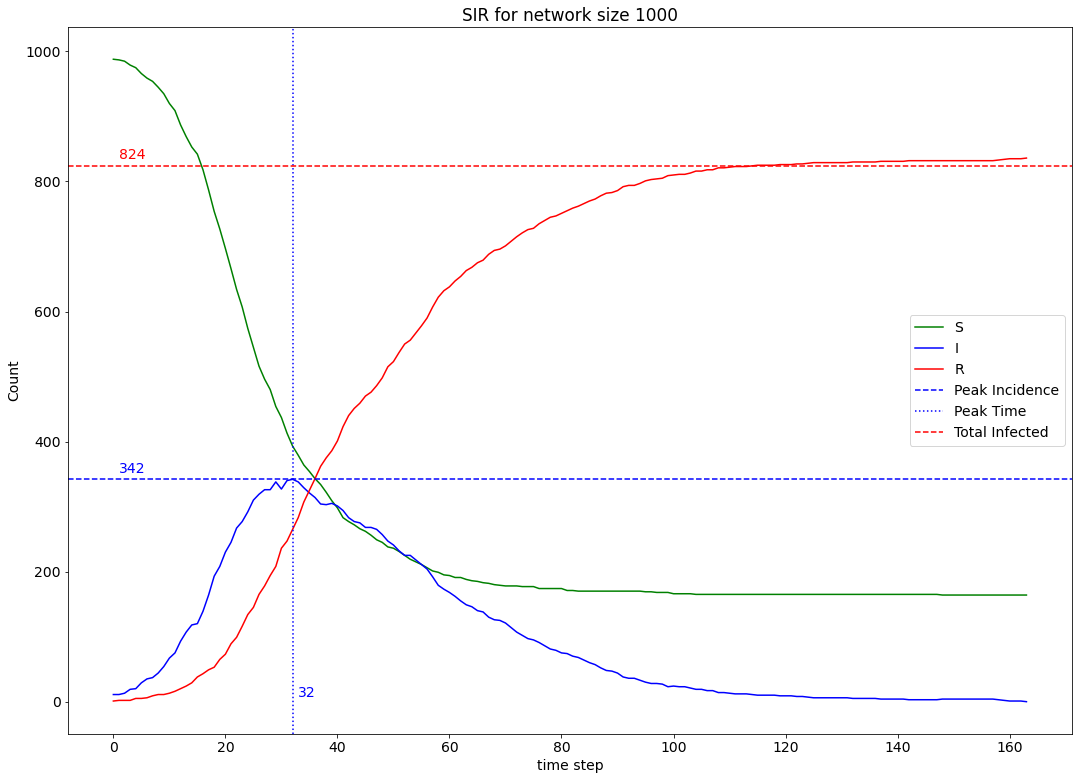

In [9]:
reset(ba) 
S, I, R, endtime, ii = run_spread_simulation(ba, m, number_initial_infections)
plot_infection(S,I,R,ba) 

**The peak time is at time_step = 32. Total infected is 824 (out of 1000 nodes/people).**

## Vaccination by degree

Now, let's develop a vaccination strategy. Here, the number of vaccinations to apply is specified; The first strategy is to vaccinate the nodes (people) with the highest degree. In other words, the node (person) with the most of number of connections to other nodes (interactions) will be vaccinated first. Vaccination in this case means their 'state' is removed, i.e., they're already resilient to the the disease.

The network is reset to be all susceptible, then the vaccination strategy is applied, experiments are re-run. 

In [10]:
number_to_vacinate = 10

def vacinate_by_degree(G, num_to_vacinate):
    degrees = G.degree() 
    nodes_sorted_by_degree = sorted(dict(degrees()).items(), key=operator.itemgetter(1), reverse=True) 
    for x in range(num_to_vacinate): 
        node_id_to_vacinate = nodes_sorted_by_degree[x]
        G.nodes[node_id_to_vacinate[0]]['state'] = State.Removed 


Infected: 0 time step: 2230

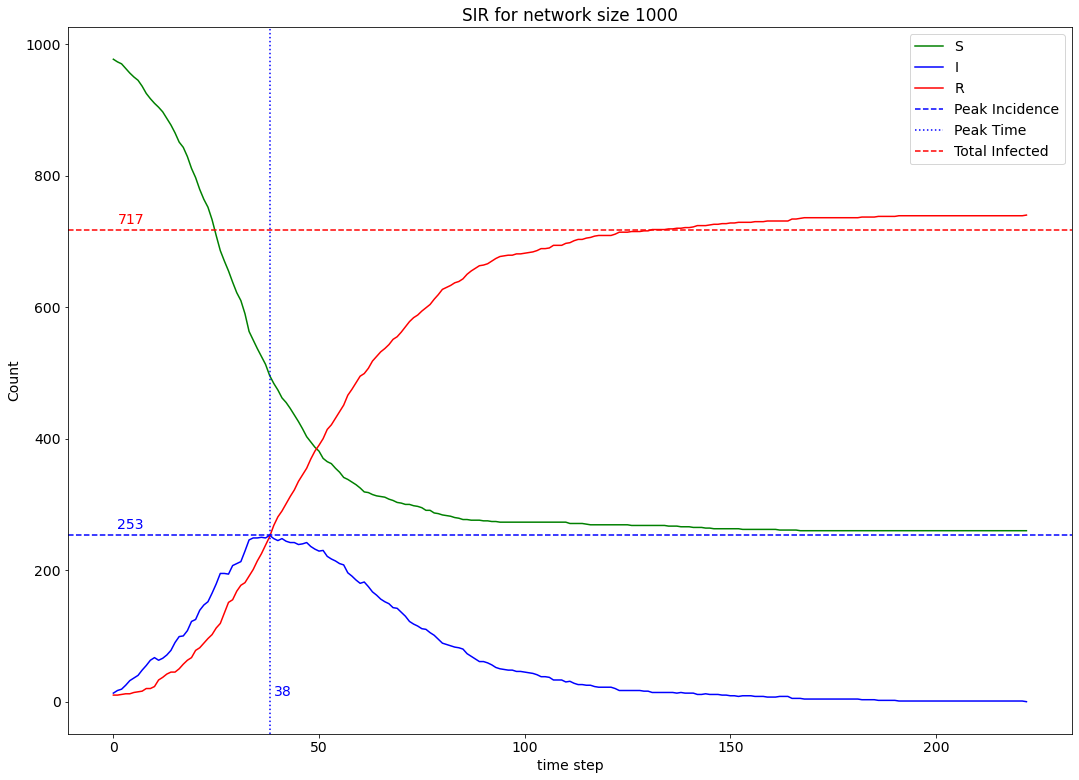

In [11]:
# rerun single simulation of vaccination
reset(ba)        
vacinate_by_degree(ba, number_to_vacinate)
S, I, R, endtime,ii = run_spread_simulation(ba, m, number_initial_infections)
plot_infection(S,I,R,ba)

Note that initial infections are random, i.e., there is a stochastic nature introduced in the network. **By including a vaccination strategy, the peak-time has increased/delayed to time step = 38. Number of total infected is also reduced to 717 (out of 1000 nodes/people).** Obviously, when vaccination is introduced, the number of people infected has decreased, and the time step to reach peak infection is delayed.

## Vaccination by betweenness

Now, let's try a different strategy for vaccination and vaccinate the nodes with the highest betweenness centrality. 'Betweenness' measures the number of shortest paths that a node lies on. In other words, the node (person) most likely to act as a bridge along/between other nodes. 
The betweenness centrality on node $n_j$ is defined as:

$$ 
g(n_j) \sum_{i \neq j \neq k} = \frac{\sigma_{n_in_k}(n_j)} {\sigma_{n_in_k}}$$

where $\sigma_{n_in_k}$ is the total number of shortest paths from node $n_i$ to $n_k$ and $\sigma_{n_in_k}(n_j)$ is the number of those paths that pass through node $n_j$


In [12]:
def vacinate_by_betweenness(G, number):
    bet_cen = nx.betweenness_centrality(G)
    nodes_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)
    for x in range(number):
        node_id_to_vacinate = nodes_sorted_by_betweenness[x]
        G.nodes[node_id_to_vacinate[0]]['state'] = State.Removed  


Infected: 0 time step: 2346

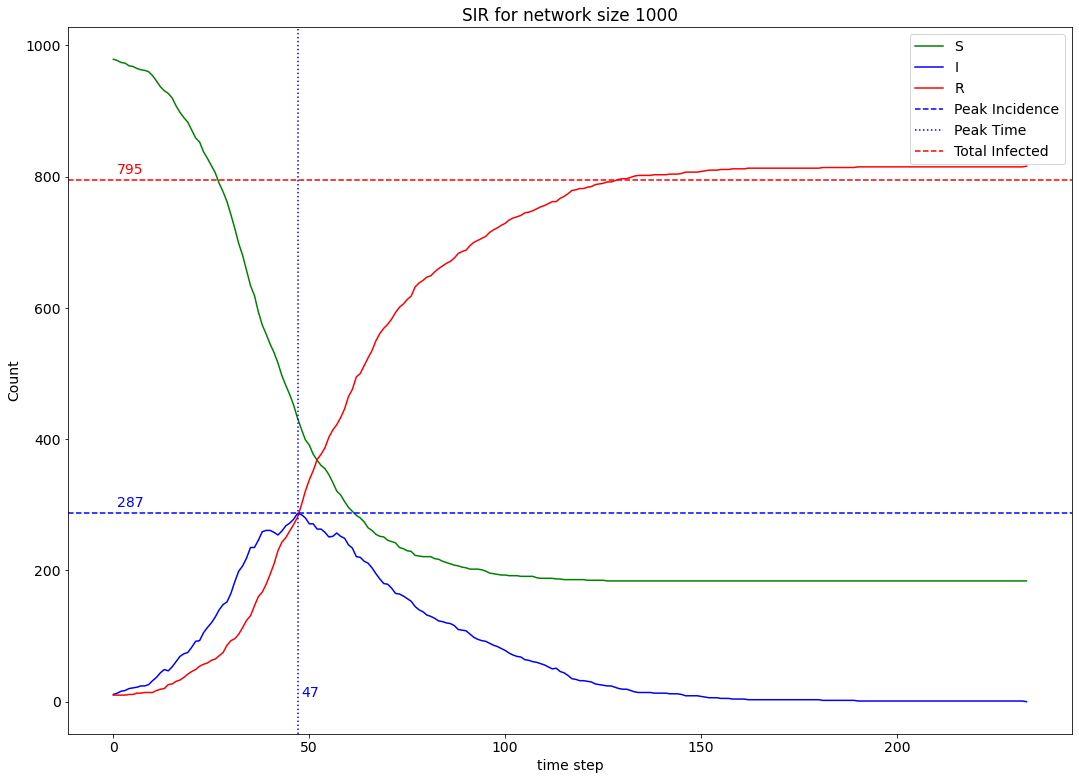

In [13]:
reset(ba)        
vacinate_by_betweenness(ba, number_to_vacinate)
S, I, R, endtime,ii = run_spread_simulation(ba, m, number_initial_infections)
plot_infection(S,I,R,ba)

**By changing the vaccination strategy (to betweenness), the peak-time was increased/delayed to time step = 47. This is still higher than without a vaccination strategy. Number of total infected is also reduced to 795 (out of 1000 nodes/people), compared to having no vaccination strategy.**
<br> Vaccinating the node (person) with the highest degree will be more effective against the disease, since the person will have the most personal interactions with other people. In reality, it is hard to implement, because should we vaccinate people based on the number of 'friends' in facebook/ instagram? 

## Visualisation in bokeh

NetworkX does not have great visualisation capabilities built in, but we can try bokeh that creates nice interactive plots. 

In [14]:
from bokeh.plotting import *

output_notebook()

# create a new plot with a title and axis labels
p = figure(title="SIR model", x_axis_label='time step', y_axis_label='count', plot_width=1000, plot_height=800)
xvalues = range(len(S))
# add a line renderer with legend and line thickness
p.line(xvalues, S, legend="Susceptible", line_width=2, line_color="green")
p.line(xvalues, I, legend="Infected", line_width=2, line_color="blue")
p.line(xvalues, R, legend="Recovered", line_width=2, line_color="red")

# show the results
show(p)


Loading BokehJS ...

## Deciding on a Strategy with Incomplete Information

If we run the above experiments repeatedly, we will see that in some cases no outbreak occurs, or a very limited outbreak occurs. The only initial condition that changes in the experiments is the set of nodes that were initially infected. This  is chosen randomly inside the **initialise_infection** function, performed with command **random.sample**. If that initial random sample of people from the graph just so happens to hit one important node (highly connected) the likelihood of an outbreak occurring is high. However, if the sample only contains nodes with very low degree (e.g., 1), then there is good chance that those node will be removed (state 'R'). This is also dependent on the disease and the values of $\beta$ and $\alpha$.

This level of known and unknown parameters are somewhat realistic. In reality, policy makers may have information and data for different aspects of the pandemic. For example, they may have some idea about the network structure, but not all, they may also have an approximation (or range) for $\beta$ and $\alpha$, through data collected at hospitals. However, they will almost never have all the information necessary to make a prediction. In this case, it's necessary to assess the sensitivity of the results according to each unknown (and perhaps known) parameter.

### Case scenario

**Assuming a contact network that is scale-free. The question is: is it better to vaccinate 
<br> (a) nodes with higher degree or 
<br> (b) nodes with higher betweenness?**

There are a number of situations that the answer might depend on; The control parameters are: 1. Method, 2. Number of Vaccinations, 3. Number of initial infections. There is also a stochastic parameter - the set of nodes that are initially infected, which will vary randomly.

There is also the assumption that we already know the network (i.e., use a fixed network instance, with a fixed size), and the disease parameters - $\alpha = 0.05$, and $\beta = 0.03$, i.e., at each time step, a node will infect each neighbour with a 3% chance, and has a 5% chance to recover/be removed.

In [15]:
# create network
N = 1000 
ba = nx.barabasi_albert_graph(N, 4) 

reset(ba) 
m = transmission_model_factory(0.03, 0.05) 

#create a range on initial infection/vaccination counts
fraction_initial_infections = [5e-3, 5e-2] 
fraction_vaccinations = [5e-3, 1e-2] 

vacination_methods = [vacinate_by_betweenness, vacinate_by_degree]
repetitions = 3 # number of times to run each instance (i.e., vary the starting infection locations)

results = []
for method in vacination_methods:
    for inf in fraction_initial_infections:
        for vac_fraction in fraction_vaccinations:
            total_peak_incidence = total_peak_time = total_total_infected = 0
            for rep in range(1,repetitions+1):
                reset(ba)
                method(ba, int(vac_fraction*N))
                S, I, R, endtime, ii = run_spread_simulation(ba, m, int(N*inf))
                total_peak_incidence += max(I)
                total_peak_time += I.index(max(I))
                total_total_infected += S[0]-S[-1]
            ave_peak_incidence = total_peak_incidence / rep
            ave_peak_time = total_peak_time / rep
            ave_total_infected = total_total_infected / rep
            results.append((method.__name__, inf, vac_fraction,ave_peak_incidence,ave_peak_time,ave_total_infected))
                
print(results)

Infected: 0 time step: 1854

[('vacinate_by_betweenness', 0.005, 0.005, 363.6666666666667, 38.0, 882.0), ('vacinate_by_betweenness', 0.005, 0.01, 376.0, 37.0, 862.0), ('vacinate_by_betweenness', 0.05, 0.005, 400.6666666666667, 20.0, 831.0), ('vacinate_by_betweenness', 0.05, 0.01, 371.3333333333333, 20.666666666666668, 813.3333333333334), ('vacinate_by_degree', 0.005, 0.005, 383.6666666666667, 32.0, 879.0), ('vacinate_by_degree', 0.005, 0.01, 329.0, 41.333333333333336, 860.3333333333334), ('vacinate_by_degree', 0.05, 0.005, 422.3333333333333, 22.0, 844.0), ('vacinate_by_degree', 0.05, 0.01, 364.3333333333333, 26.333333333333332, 822.6666666666666)]


In [16]:
# present in table form
pd.DataFrame(data=results,columns=['method','initial_infection','vac_fraction','ave_peak_incidence','ave_peak_time','ave_total_infected'])

,method,initial_infection,vac_fraction,ave_peak_incidence,ave_peak_time,ave_total_infected
0,vacinate_by_betweenness,0.005,0.005,363.666667,38.000000,882.000000
1,vacinate_by_betweenness,0.005,0.010,376.000000,37.000000,862.000000
2,vacinate_by_betweenness,0.050,0.005,400.666667,20.000000,831.000000
3,vacinate_by_betweenness,0.050,0.010,371.333333,20.666667,813.333333
4,vacinate_by_degree,0.005,0.005,383.666667,32.000000,879.000000
5,vacinate_by_degree,0.005,0.010,329.000000,41.333333,860.333333
6,vacinate_by_degree,0.050,0.005,422.333333,22.000000,844.000000
7,vacinate_by_degree,0.050,0.010,364.333333,26.333333,822.666667
